# HCM rates by Clinvar and Risk 
##### Updated 07/25/2024
##### Selin Kubali

#### Goal:
Graph HCM rates for high-risk and low-risk patients in different Clinvar categories across all genes with models.
#### Required inputs
Lifelines files - Stored in */selected_genes/hcm/cox_model_data*. 

Variant data files - Stored in */selected_genes/hcm/variant_files*.

Clinvar data - Stored in */selected_genes/hcm/csv_files/variant_summary.txt*

##### Load packages

In [1]:
!pip install lifelines --quiet --root-user-action=ignore
!pip install scikit-learn --quiet --root-user-action=ignore
!pip install matplotlib --quiet --root-user-action=ignore
!pip install --upgrade pandas

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dxdata 0.41.0 requires pandas==1.5.3; python_version >= "3.8", but you have pandas 2.2.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from scipy.stats import ttest_ind
import seaborn as sns
from random import choices
from scipy.stats import chi2_contingency
import random


plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore")

variant_summary_file = 'variant_summary.txt'

### Download variant summary file

In [ ]:
def download_gene(variant_summary_path = '/selected_genes/hcm/csv_files/', variant_summary_name = variant_summary_file):
    variant_summary_file_name = variant_summary_file + '.gz'
    variant_summary_path = variant_summary_path + variant_summary_file_name
    !dx download $variant_summary_path
    !gzip -d $variant_summary_file_name
download_gene()

#### Define global variables

In [23]:
risk = ['High','Low']
clinvar_list = ['P/LP','Uncertain','Conflicting','B/LB','Syn']
genes = ['ACTN2', 'ALPK3', 'FLNC', 'MYBPC3', 'MYH6', 'MYH7']

#### Calculate overall HCM rate


In [5]:
hcm_rate_overall = pd.read_csv(f'/mnt/project/selected_genes/hcm/cox_model_data/ACTN2_with_generated_data.csv', 
                                     dtype = {'duration':'float', 'is_HCM':'boolean', 'sex':'boolean',
                                              'is_family_hist':'boolean', 'is_AF':'boolean',
                                              'is_HTN': 'boolean', 'am_pathogenicity':'float'})['is_HCM'].mean()

#### Load cross-validation gene models

In [7]:
def cross_val(gene, only_variant_info = False, dir_path_variant="selected_genes/hcm/variant_files", dir_path_cox = "selected_genes/hcm/cox_model_data"):
        """ Load variant data, individual patient data, and clinvar data. Runs cross-validation on individual patient data to predict risk of developing HCM. Cleans and joins files and returns a file with individual patient data, individual patient hazard scores, and clinvar pathogenicity data.
        """


        cph = CoxPHFitter(penalizer = 0.001)
        
        
        
        # load lifelines file


        lifelines_data = pd.read_csv(f'/mnt/project/{dir_path_cox}/{gene}_with_generated_data.csv', 
                                     dtype = {'Name':'str','duration':'float', 'is_HCM':'boolean', 'sex':'boolean',
                                              'is_family_hist':'boolean', 'is_AF':'boolean',
                                              'is_HTN': 'boolean', 'am_pathogenicity':'float','Consequence':'str', 
                                              'Confidence':'str','faf_max':'float','revel_max':'float',
                                             'cadd_raw_score':'float','phylop':'float', 'spliceai_ds_max':'float'})
        
       
        
        
        lifelines_data['prs_score'] = (lifelines_data['prs_score'] - lifelines_data['prs_score'].min()) / (lifelines_data['prs_score'].max() - lifelines_data['prs_score'].min())     
        lifelines_data['am_pathogenicity'] = (lifelines_data['am_pathogenicity'] - lifelines_data['am_pathogenicity'].min()) / (lifelines_data['am_pathogenicity'].max() - lifelines_data['am_pathogenicity'].min())     
        lifelines_data['cadd_raw_score'] = (lifelines_data['cadd_raw_score'] - lifelines_data['cadd_raw_score'].min()) / (lifelines_data['cadd_raw_score'].max() - lifelines_data['cadd_raw_score'].min())     
        lifelines_data['phylop'] = (lifelines_data['phylop'] - lifelines_data['phylop'].min()) / (lifelines_data['phylop'].max() - lifelines_data['phylop'].min())     
        lifelines_data['faf_max'] = (lifelines_data['faf_max'] - lifelines_data['faf_max'].min()) / (lifelines_data['faf_max'].max() - lifelines_data['faf_max'].min())     

        no_variant = lifelines_data[~lifelines_data['Consequence'].isin(['synonymous_variant','deleterious','missense_variant'])]
        hcm_no_variant = no_variant['is_HCM'].sum()
        total_no_variant = no_variant['is_HCM'].count()

        lifelines_data = lifelines_data[lifelines_data['Consequence'].isin(['synonymous_variant','deleterious','missense_variant'])]
        lifelines_data.loc[lifelines_data['Consequence'] == 'deleterious', 'am_pathogenicity'] = 1
        lifelines_data.loc[lifelines_data['Consequence'] == 'synonymous_variant', 'am_pathogenicity'] = 0
        


        if 'revel_max' in lifelines_data.columns:
            variant_level_features = ['am_pathogenicity','cadd_raw_score','faf_max','phylop','spliceai_ds_max','revel_max']
        else:
            variant_level_features = ['am_pathogenicity','cadd_raw_score','faf_max','phylop','spliceai_ds_max']

        demographic_level_features = ['is_HTN', 'is_AF', 'prs_score', 'sex', 'is_family_hist']
        if only_variant_info == True:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features]

        else:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features + demographic_level_features]

    

        variant_data = pd.read_csv(f'/mnt/project/{dir_path_variant}/{gene}_variants.csv')

        variant_data_name = variant_data[['Name']]
        variant_data_name= variant_data_name.dropna()

        # set lifelines data index to variant data index
        variant_data_name['var_index'] = variant_data_name.index
        lifelines_data = variant_data_name.merge(lifelines_data, how="outer")
        lifelines_data.set_index("var_index")
        lifelines_data=lifelines_data.dropna()
        lifelines_data = lifelines_data.drop_duplicates(subset=['Carrier'])


        # load, clean, and merge clinvar information
        clinvar_df = pd.read_csv(variant_summary_file, sep = '\t', dtype = {'Chromosome':'str'})
        clinvar_df = clinvar_df[clinvar_df['Assembly'] == 'GRCh38']
        clinvar_df = clinvar_df.rename(columns={"Chromosome": "Chrom", "Start": "Pos", "ReferenceAlleleVCF": "Ref", "AlternateAlleleVCF": "Alt"})
        clinvar_df = clinvar_df[["Name", "Chrom", "Pos", "Ref", "Alt", "ClinicalSignificance"]]
        clinvar_variant_df = pd.merge(variant_data, clinvar_df, how = 'left', on = ['Pos', 'Ref', 'Alt'])
        clinvar_variant_df = clinvar_variant_df.rename(columns={"Name_x": "Name"})
        clinvar_variant_df = clinvar_variant_df[["Name", "ClinicalSignificance"]]
        lifelines_data = pd.merge(lifelines_data,clinvar_variant_df, how="left", on = ['Name'])
        lifelines_data = lifelines_data.drop_duplicates(subset=['Carrier'])




        # cross validation: split up phenotypic data file based on variant file index
        kf = KFold(n_splits=5, shuffle=True, random_state=4)
        testing_set = []
        for train_idx, test_idx in kf.split(variant_data):

                train = lifelines_data[lifelines_data['var_index'].isin(train_idx)]
                test = lifelines_data[lifelines_data['var_index'].isin(test_idx)]
                train = train.drop(['var_index'], axis=1)
                test = test.drop(['var_index'], axis=1)


                # fit CPH and add hazard scores
                if only_variant_info == True:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features)
                else:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features + demographic_level_features)

                hazard_scores_fold = cph.predict_partial_hazard(test)
                test['hazard'] = hazard_scores_fold
                testing_set.append(test)
                




        # create new lifelines_data df by joining all testing sets
        lifelines_data = pd.concat([df for idx, df in enumerate(testing_set)]) 

        return lifelines_data, hcm_no_variant, total_no_variant



#### Calculate and split on threshold

In [124]:
def find_threshold_vals(gene, only_variant_info = False):
    
    """ Runs CoxPH cross-validation with the chosen threshold for a gene."""

    if only_variant_info == True:
        print("Model with only variant-level features")
        lifelines_data, hcm_no_variant, total_no_variant = cross_val(gene, only_variant_info = True)
    else:
        print("Model with all features")
        lifelines_data, hcm_no_variant, total_no_variant = cross_val(gene)

    # grouping and renaming Clinvar variants
    lifelines_data = lifelines_data[lifelines_data['ClinicalSignificance'] != 'not provided']
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 'Likely pathogenic']), 'ClinicalSignificance')] = 'P/LP'
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign']), 'ClinicalSignificance')] = 'B/LB'
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Conflicting classifications of pathogenicity']), 'ClinicalSignificance')] = 'Conflicting'
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Uncertain significance']), 'ClinicalSignificance')] = 'Uncertain'

    lifelines_data['is_HCM'] = lifelines_data['is_HCM'].astype('int64')
    lifelines_data_synonymous = lifelines_data[(lifelines_data['am_pathogenicity'] == 0)]
    lifelines_data = lifelines_data[(lifelines_data['am_pathogenicity'] != 0)]

    # threshold calculation
    fpr, tpr, thresholds = metrics.roc_curve(lifelines_data['is_HCM'], lifelines_data['hazard'], pos_label = 1)
    roc_auc = metrics.auc(fpr, tpr)
    lifelines_data_vus = lifelines_data[~lifelines_data['ClinicalSignificance'].isin(['B/LB', 'P/LP'])]
    vus_hazard_min = lifelines_data_vus[lifelines_data_vus['is_HCM'] == 1]['hazard'].min()
    vus_hazard_max = lifelines_data_vus[lifelines_data_vus['is_HCM'] == 1]['hazard'].max()
    min_index = np.argmin(np.abs(np.array(thresholds)-vus_hazard_min)) # vus min should be larger than any other variable
    max_index = np.argmin(np.abs(np.array(thresholds)-vus_hazard_max))
    tpr_limited = tpr[max_index:min_index]
    fpr_limited = fpr[max_index:min_index]
    thresholds = thresholds[max_index:min_index]
    optimal_idx = np.argmax(tpr_limited - fpr_limited)
    hazard = thresholds[optimal_idx]
    
    
    # splitting dataset on risk
    lifelines_data['Risk'] = np.where(lifelines_data['hazard'] > hazard, 'High', 'Low')
    lifelines_data_synonymous['Risk'] = np.where(lifelines_data_synonymous['hazard'] > hazard, 'High', 'Low')
    #lifelines_data = lifelines_data[lifelines_data['am_pathogenicity'] != 1] #remove lof

    lifelines_data_synonymous['ClinicalSignificance'] = 'Syn'
    lifelines_data_non_syn = lifelines_data
    lifelines_data = pd.concat([lifelines_data, lifelines_data_synonymous])

    # grouping by risk and clinical significance
    hcm_count = pd.DataFrame(lifelines_data.groupby(['ClinicalSignificance','Risk'])['is_HCM'].sum()).reset_index().pivot(columns = 'Risk', index = 'ClinicalSignificance', values = 'is_HCM')
    total_count = pd.DataFrame(lifelines_data.groupby(['ClinicalSignificance','Risk'])['is_HCM'].count()).reset_index().pivot(columns = 'Risk', index = 'ClinicalSignificance', values = 'is_HCM')
    

    # calculate number of patients with hcm and total number of patients by Clinvar and risk 
    dif = list(set(hcm_count.index.tolist()) ^ set(clinvar_list))
    if len(dif) > 0: # add any missing clinvar groups
        hcm_count = pd.concat([hcm_count, pd.DataFrame({'ClinicalSignificance':dif,'High': [0]*len(dif), 'Low':[0]*len(dif)}).set_index('ClinicalSignificance')])

    dif = list(set(total_count.index.tolist()) ^ set(clinvar_list))
    if len(dif) > 0: # add any missing clinvar groups
        total_count = pd.concat([total_count, pd.DataFrame({'ClinicalSignificance':dif,'High': [0]*len(dif), 'Low':[0]*len(dif)}).set_index('ClinicalSignificance')])
    
    return hcm_count,total_count,lifelines_data

#### Calculate HCM rates across all genes in 'genes'

In [125]:
def load_lifelines_data(genes, clinvar_list):
    
    lifelines_data = pd.DataFrame()
    
    risk_dict = {}
    hcm_count, total_count = [pd.DataFrame({
        'ClinicalSignificance': ['P/LP', 'Uncertain', 'Conflicting', 'B/LB', 'Syn'],
        'High': [0]*5,
        'Low': [0]*5,
        }).set_index('ClinicalSignificance')]*2

    for gene in genes:
        hcm,total,lifelines_data_new = find_threshold_vals(gene)
        lifelines_data = pd.concat([lifelines_data, lifelines_data_new])
        hcm.fillna(0, inplace = True)
        total.fillna(0, inplace = True)
        hcm_count, total_count = hcm + hcm_count, total + total_count

    
    for pathogenicity in clinvar_list:
        filtered_df = lifelines_data[lifelines_data['ClinicalSignificance'] == pathogenicity]
        cont = pd.crosstab(filtered_df['Risk'], filtered_df['is_HCM'])
        print(cont)
        result_p = "{:.{}g}".format(chi2_contingency(cont)[1], 2)
        risk_dict[pathogenicity] = result_p
        
    hcm_rates = hcm_count / total_count 
    hcm_rates['Overall'] = (hcm_count['High'] + hcm_count['Low']) / (total_count['High'] + total_count['Low'])
    hcm_rates.fillna(0, inplace = True)
    hcm_rates = hcm_rates.reindex(clinvar_list)


    
    lifelines_data_variant = pd.DataFrame()
    risk_dict_variant = {}
    hcm_count, total_count = [pd.DataFrame({
        'ClinicalSignificance': ['P/LP', 'Uncertain', 'Conflicting', 'B/LB', 'Syn'],
        'High': [0]*5,
        'Low': [0]*5}).set_index('ClinicalSignificance')]*2

    for gene in genes:
        hcm,total,lifelines_data_new = find_threshold_vals(gene, only_variant_info = True)
        hcm.fillna(0, inplace = True)
        total.fillna(0, inplace = True)
        lifelines_data_variant = pd.concat([lifelines_data_variant, lifelines_data_new])
        hcm_count, total_count = hcm + hcm_count, total + total_count


    for pathogenicity in clinvar_list:
        filtered_df = lifelines_data_variant[lifelines_data_variant['ClinicalSignificance'] == pathogenicity]
        cont = pd.crosstab(filtered_df['Risk'], filtered_df['is_HCM'])
        print(cont)
        result_p = "{:.{}g}".format(chi2_contingency(cont)[1], 2)
        risk_dict_variant[pathogenicity] = result_p
        
        
    hcm_rates_variant = hcm_count / total_count
    hcm_rates_variant['Overall'] = (hcm_count['High'] + hcm_count['Low']) / (total_count['High'] + total_count['Low'])
    hcm_rates_variant.fillna(0, inplace = True)
    hcm_rates_variant = hcm_rates_variant.reindex(clinvar_list)
    
    
    return lifelines_data, lifelines_data_variant, hcm_rates, hcm_rates_variant, risk_dict, risk_dict_variant

In [126]:
lifelines_data, lifelines_data_variant, hcm_rates, hcm_rates_variant, risk_dict, risk_dict_variant = load_lifelines_data(genes, clinvar_list)

Model with all features
Model with all features
Model with all features
Model with all features
Model with all features
Model with all features
is_HCM    0   1
Risk           
High    327  36
Low     355  15
is_HCM      0   1
Risk             
High     4280  36
Low     17762  15
is_HCM      0   1
Risk             
High     2536  24
Low     17241  12
is_HCM     0   1
Risk            
High     320  10
Low     2213   1
is_HCM      0   1
Risk             
High     3662  15
Low     24104  28
Model with only variant-level features
Model with only variant-level features
Model with only variant-level features
Model with only variant-level features
Model with only variant-level features
Model with only variant-level features
is_HCM    0   1
Risk           
High    403  35
Low     285  16
is_HCM      0   1
Risk             
High     7316  24
Low     14926  27
is_HCM      0   1
Risk             
High     5674  15
Low     14259  21
is_HCM     0   1
Risk            
High     235   1
Low     2327  1

In [123]:
risk_dict_variant

{'P/LP': '0.31',
 'Uncertain': '0.081',
 'Conflicting': '0.24',
 'B/LB': '0.8',
 'Syn': '1'}

#### Sample from each (Clinvar group, risk) combination with replacement. Find mean for 5000 samples in each group.

In [127]:
def bootstrapping(lifelines_data, clinvar_list):
    risk = ['High', 'Low']
    sample_dict = pd.DataFrame({'Clinvar':[], 'Risk': [],'Value': []})
    for i in clinvar_list:
        for j in risk:
            clinvar_risk = (lifelines_data[(lifelines_data['ClinicalSignificance'] == i) & (lifelines_data['Risk'] == j)])
            print(i, j, len(clinvar_risk))
            for k in range(5000):
                sample = random.choices(clinvar_risk['is_HCM'].tolist(), k=len(clinvar_risk))
                avg = np.mean(sample)
                sample_dict = pd.concat([sample_dict, pd.DataFrame({'Clinvar':[i], 'Risk':[j], 'Value':[avg]})])
                
        clinvar_risk = (lifelines_data[lifelines_data['ClinicalSignificance'] == i])
        print(i, 'Overall', len(clinvar_risk))
        for k in range(5000):
            sample = random.choices(clinvar_risk['is_HCM'].tolist(), k=len(clinvar_risk))
            avg = np.mean(sample)
            sample_dict = pd.concat([sample_dict, pd.DataFrame({'Clinvar':[i], 'Risk':['Overall'], 'Value':[avg]})])

    return sample_dict

In [128]:
bootstrap = bootstrapping(lifelines_data, clinvar_list)
bootstrap_variant = bootstrapping(lifelines_data_variant, clinvar_list)

P/LP High 363
P/LP Low 370
P/LP Overall 733
Uncertain High 4316
Uncertain Low 17777
Uncertain Overall 22093
Conflicting High 2560
Conflicting Low 17253
Conflicting Overall 19813
B/LB High 330
B/LB Low 2214
B/LB Overall 2544
Syn High 3677
Syn Low 24132
Syn Overall 27809
P/LP High 438
P/LP Low 301
P/LP Overall 739
Uncertain High 7340
Uncertain Low 14953
Uncertain Overall 22293
Conflicting High 5689
Conflicting Low 14280
Conflicting Overall 19969
B/LB High 236
B/LB Low 2337
B/LB Overall 2573
Syn High 5648
Syn Low 22416
Syn Overall 28064


In [134]:
def find_error_bars(bootstrap, bootstrap_variant, lifelines_data, lifelines_data_variant, clinvar_list, risk):
    """ Run bootstrapping for model with patient- and variant-level and features and model with variant-level features and find 95% CI for each group."""
    percentile_df = pd.DataFrame()
    percentile_df_variant = pd.DataFrame()
    percentiles = [2.5, 97.5]
    risk = ['High', 'Low', 'Overall']

    for i in clinvar_list:
        for j in risk:
            for k in percentiles:
                ci = np.percentile(bootstrap[(bootstrap['Clinvar'] == i) & (bootstrap['Risk'] == j)]['Value'], k)
                percentile_df = pd.concat([percentile_df, pd.DataFrame({'Clinvar':[i], 'Risk':[j], 'Percentiles': [str(k)], 'Value':[ci]})])

                ci = np.percentile(bootstrap_variant[(bootstrap_variant['Clinvar'] == i) & (bootstrap_variant['Risk'] == j)]['Value'], k)
                percentile_df_variant = pd.concat([percentile_df_variant, pd.DataFrame({'Clinvar':[i], 'Risk':[j], 'Percentiles': [str(k)], 'Value':[ci]})])            
       

    variants = []
    for i in [percentile_df, percentile_df_variant]:
        error_dfs = []
        for r in risk:
            error_df = percentile_df[percentile_df['Risk'] == r]
            error_df['ClinicalSignificance'] = error_df['Clinvar']
            error_df = error_df.drop(['Clinvar', 'Risk'], axis = 1)
            error_df = error_df.pivot(values = 'Value', columns = 'Percentiles', index = ['ClinicalSignificance'])
            error_df = error_df.reindex(index = clinvar_list)
            error_df = error_df.transpose()
            error_df.loc['2.5'] = hcm_rates[r].transpose() - error_df.loc['2.5']
            error_df.loc['97.5'] = error_df.loc['97.5'] - hcm_rates[r].transpose()
            error_dfs.append(error_df)
        variants.append(error_dfs)
    return variants[0], variants[1]


In [135]:
error_dfs, error_dfs_variant = find_error_bars(bootstrap, bootstrap_variant, lifelines_data, lifelines_data_variant, clinvar_list, risk)

#### Create graphs

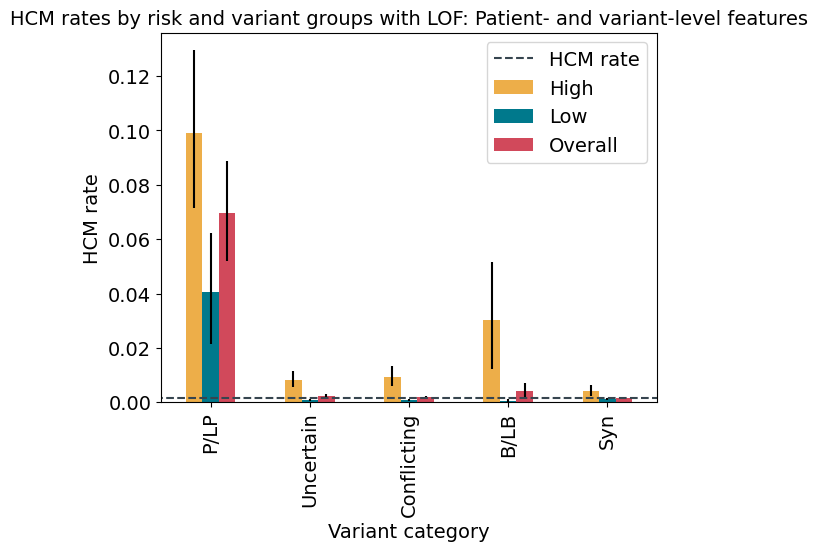

In [136]:
ax = hcm_rates.plot(kind='bar', color=['#edae49', '#00798c', '#d1495b'],yerr=(error_dfs[0],error_dfs[1],error_dfs[2]))
plt.xlabel("Variant category")
plt.ylabel("HCM rate")
plt.title("HCM rates by risk and variant groups with LOF: Patient- and variant-level features", fontdict={'fontsize':14})
plt.hlines(hcm_rate_overall, -1, 10, color = '#36454F', linestyles='dashed', label = 'HCM rate')
plt.legend()

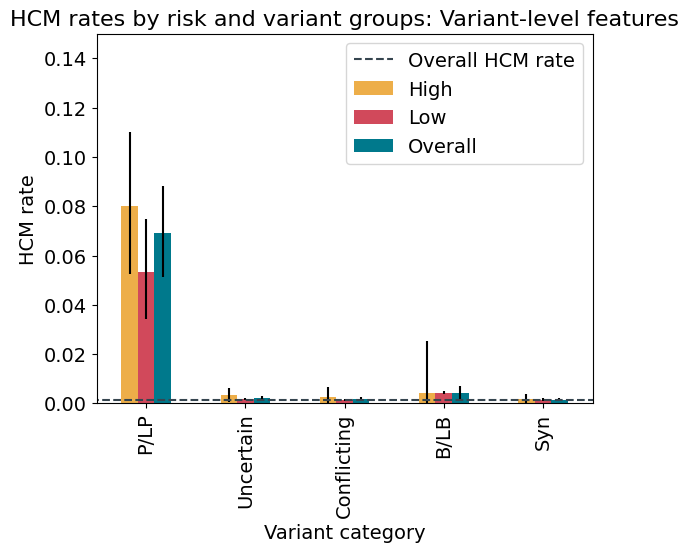

In [137]:
ax = hcm_rates_variant.plot(kind='bar', color=['#edae49', '#d1495b', '#00798c'],yerr=(error_dfs_variant[0],error_dfs_variant[1],error_dfs_variant[2]))
plt.xlabel("Variant category")
plt.ylabel("HCM rate")
plt.title("HCM rates by risk and variant groups: Variant-level features", fontdict={'fontsize':16})
plt.hlines(hcm_rate_overall, -1, 10, color = '#36454F', linestyles='dashed', label = 'Overall HCM rate')
plt.ylim((0,0.15))
plt.legend()

#### Checking assumptions

P/LP High


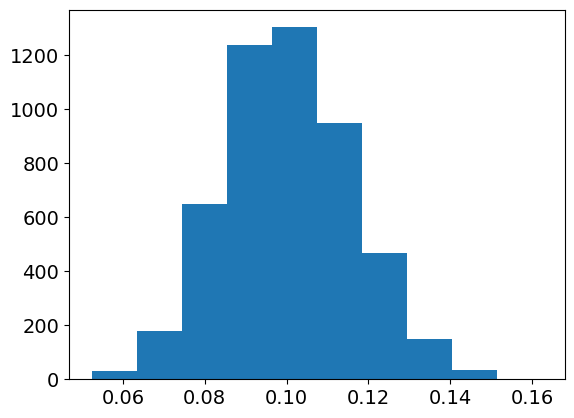

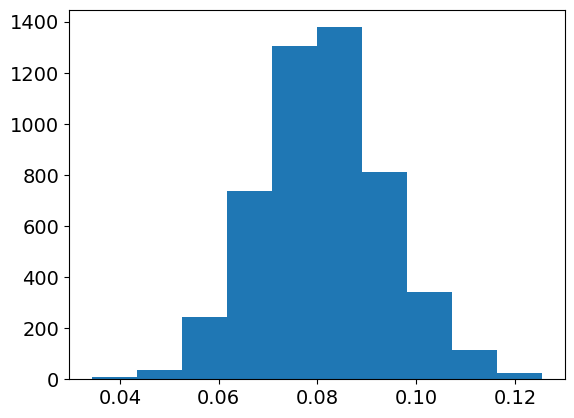

P/LP Low


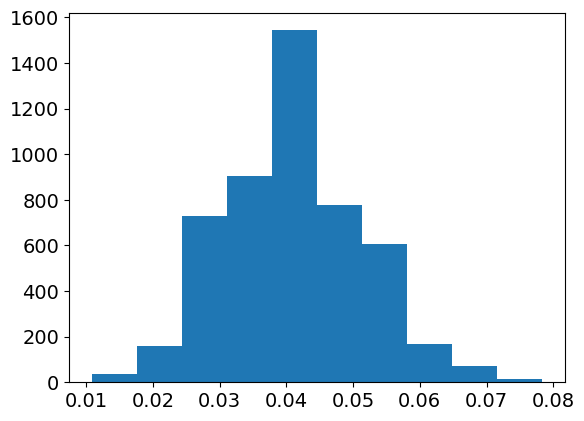

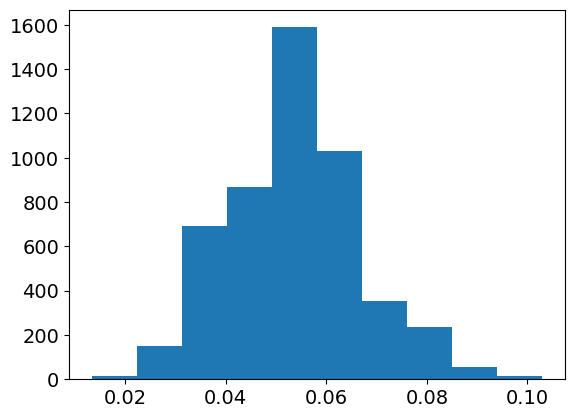

Uncertain High


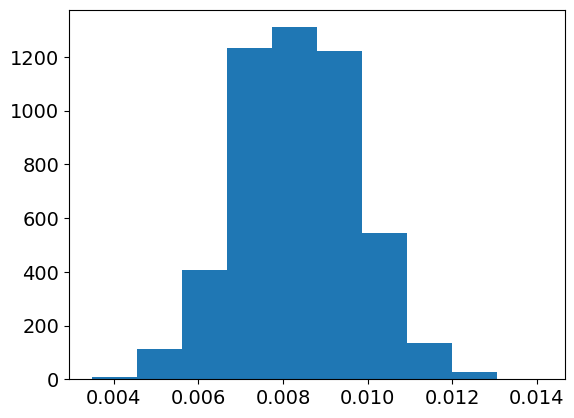

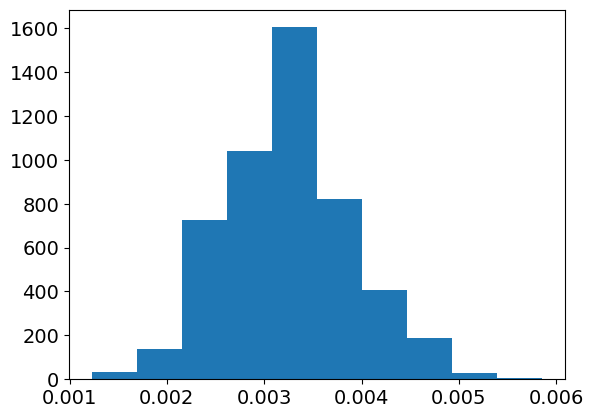

Uncertain Low


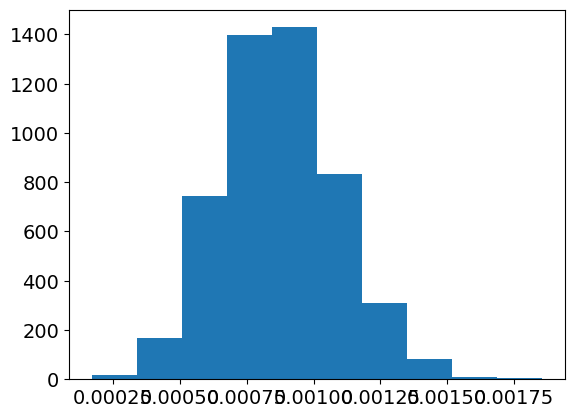

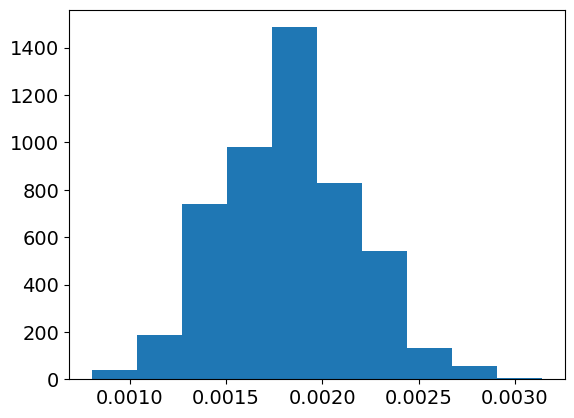

Conflicting High


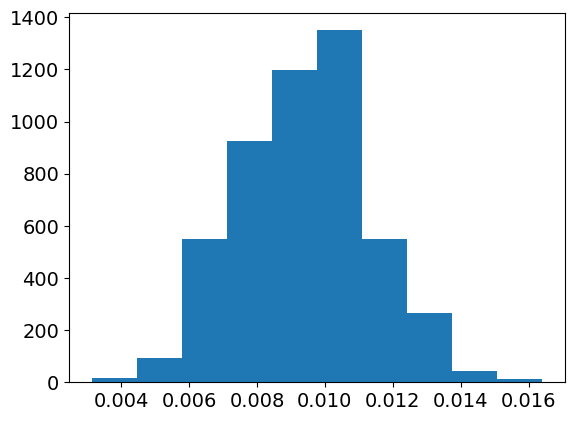

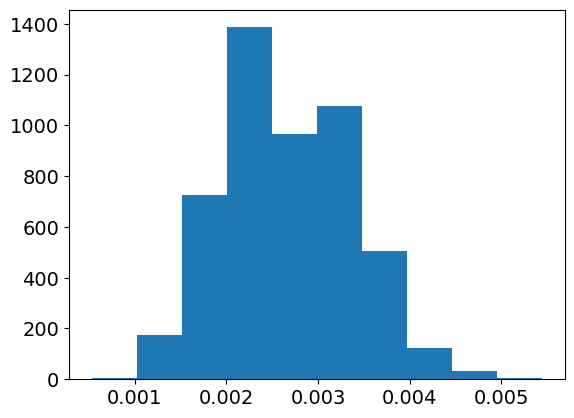

Conflicting Low


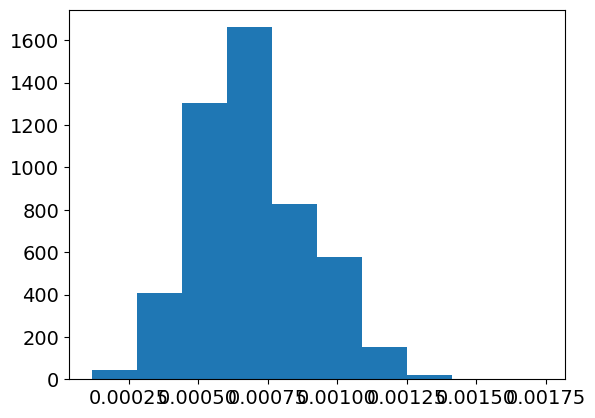

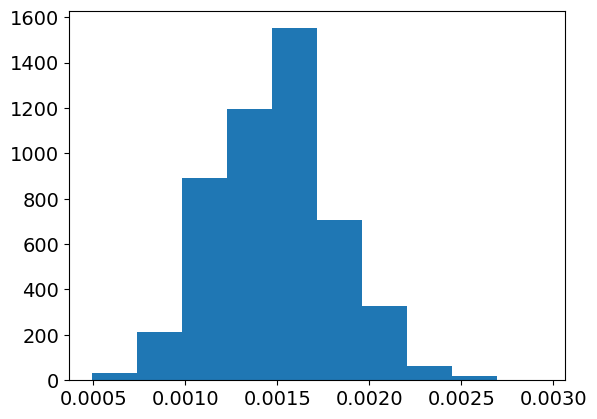

B/LB High


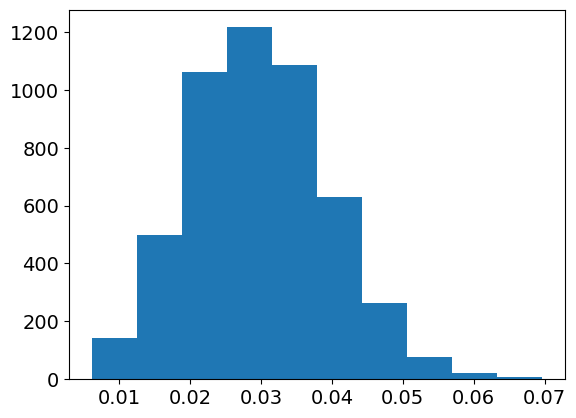

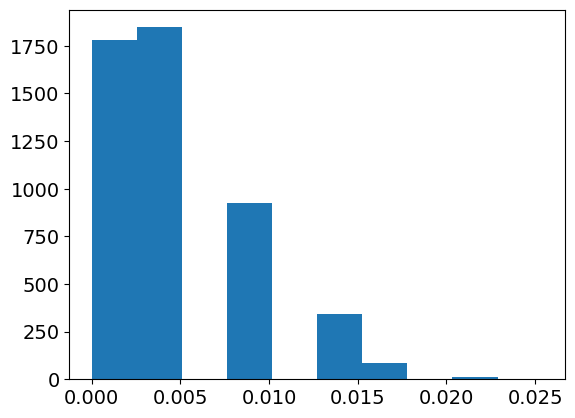

B/LB Low


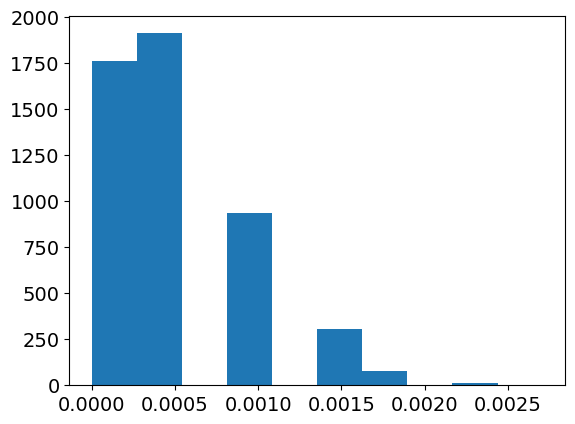

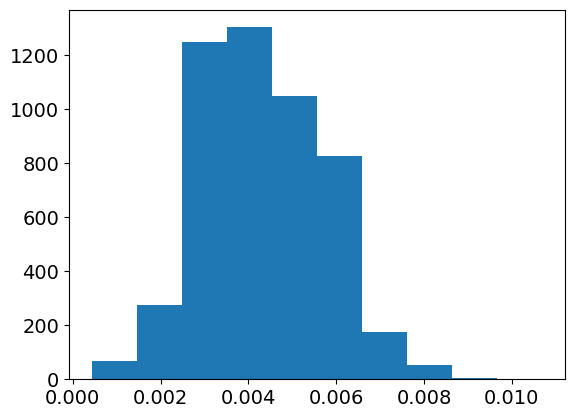

Syn High


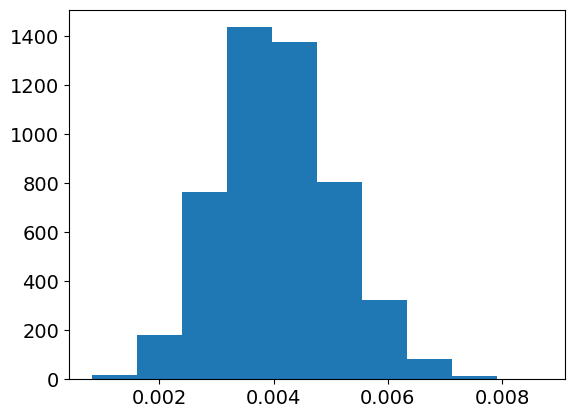

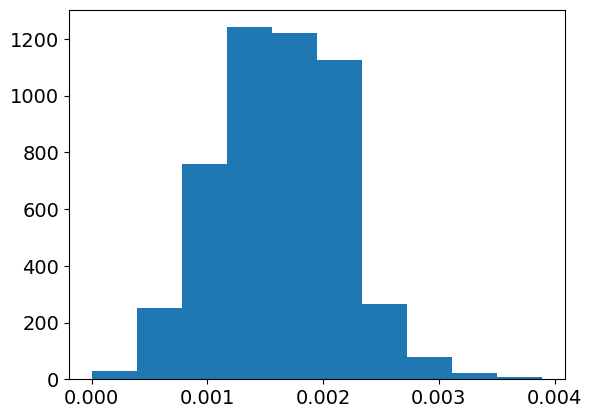

Syn Low


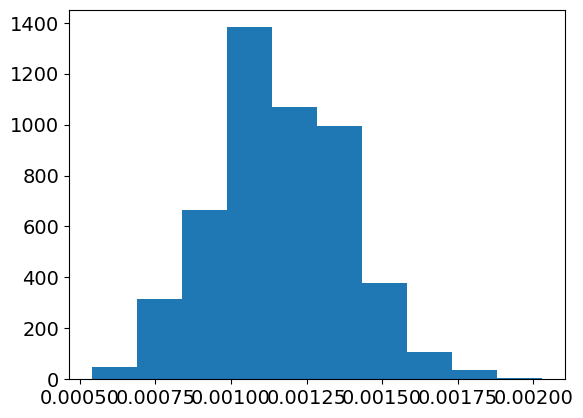

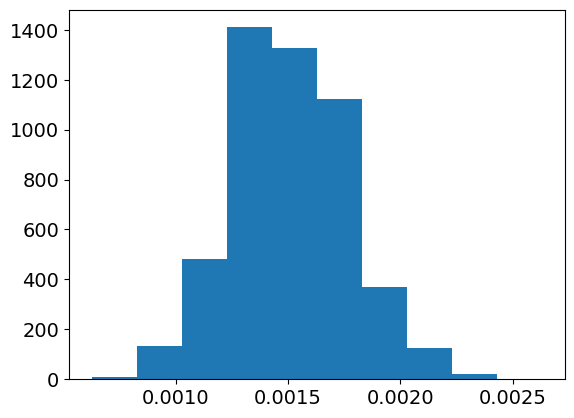

In [59]:
for i in clinvar_list:
    for j in risk:
        print(i,j)
        plt.hist(bootstrap[(bootstrap['Clinvar'] == i) & (bootstrap['Risk'] == j)]['Value'], label = 'Full')
        plt.show()
        plt.hist(bootstrap_variant[(bootstrap_variant['Clinvar'] == i) & (bootstrap_variant['Risk'] == j)]['Value'], label='Variant')
        plt.show()